<a href="https://colab.research.google.com/github/PollyBecker/Convolucionais/blob/main/Classifica%C3%A7%C3%A3o_de_Sentimentos_Tweets_com_Redes_Neurais_Convolucionais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Etapa 1: Importação das bibliotecas

In [1]:
import numpy as np
import math
import re
import pandas as pd
from bs4 import BeautifulSoup
from google.colab import drive
import zipfile
import seaborn as sns
import spacy as sp
import string
import random
import matplotlib.pyplot as plt

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.12.0'

In [3]:
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Etapa 2: Pré-processamento dos dados

## Carregamento dos arquivos

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [5]:
path = '/content/drive/My Drive/trainingandtestdata.zip'
zip_object = zipfile.ZipFile(file = path, mode = 'r')
zip_object.extractall('./')
zip_object.close()

In [6]:
cols = ['sentiment', 'id', 'date', 'query', 'user', 'text']

In [7]:
train_data = pd.read_csv('/content/trainingandtestdata/train.csv', header = None,
                         names = cols, engine = 'python', encoding = 'latin1')

In [8]:
train_data.shape

(1600000, 6)

In [9]:
train_data.head()

,sentiment,id,date,query,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [10]:
train_data.tail()

,sentiment,id,date,query,user,text
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...
1599999,4,2193602129,Tue Jun 16 08:40:50 PDT 2009,NO_QUERY,RyanTrevMorris,happy #charitytuesday @theNSPCC @SparksCharity...


In [11]:
train_data.sentiment.unique()

array([0, 4])

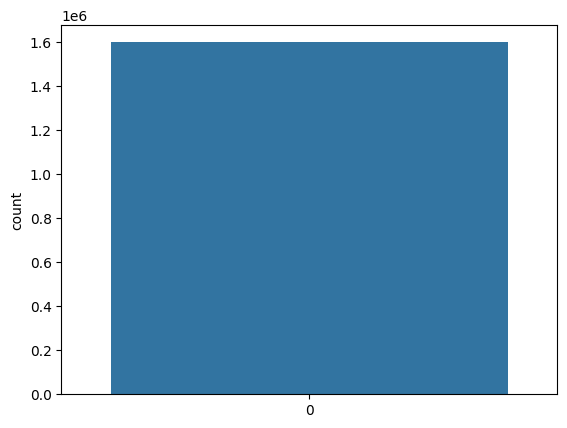

In [12]:
sns.countplot(train_data.sentiment);

In [13]:
test_data = pd.read_csv("/content/trainingandtestdata/test.csv",
    header=None,
    names=cols,
    engine="python",
    encoding="latin1"
)

In [14]:
test_data.head()

,sentiment,id,date,query,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [15]:
test_data.shape

(498, 6)

In [16]:
test_data.sentiment.unique()

array([4, 0, 2])

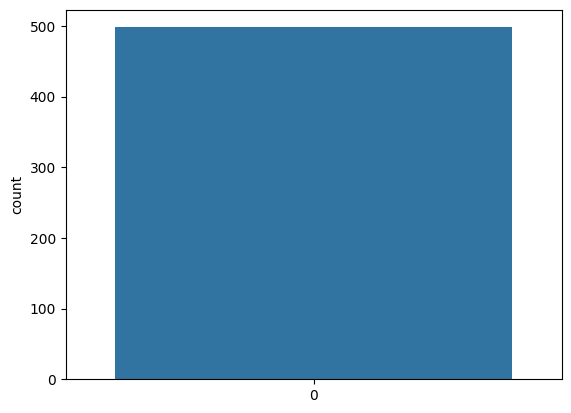

In [17]:
sns.countplot(test_data.sentiment);

## Pré-processamento

### Limpeza

In [18]:
data = train_data

In [19]:
data.drop(['id', 'date', 'query', 'user'], axis = 1, inplace=True)

In [20]:
data.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [21]:
X = data.iloc[:, 1].values

In [22]:
X

array(["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
       "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
       '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
       ..., 'Are you ready for your MoJo Makeover? Ask me for details ',
       'Happy 38th Birthday to my boo of alll time!!! Tupac Amaru Shakur ',
       'happy #charitytuesday @theNSPCC @SparksCharity @SpeakingUpH4H '],
      dtype=object)

In [23]:
X.shape

(1600000,)

In [24]:
type(X)

numpy.ndarray

In [25]:
y = data.iloc[:, 0].values
y

array([0, 0, 0, ..., 4, 4, 4])

In [26]:
from sklearn.model_selection import train_test_split
X, _, y, _ = train_test_split(X, y, test_size = 0.85, stratify = y)

In [27]:
X.shape

(240000,)

In [28]:
y.shape

(240000,)

In [29]:
unique, counts = np.unique(y, return_counts=True)
unique, counts

(array([0, 4]), array([120000, 120000]))

In [33]:
def clean_tweets(tweet):
  tweet = BeautifulSoup(tweet, 'lxml').get_text()
  tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
  tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
  tweet = re.sub(r"[^a-zA-Z.!?]", ' ', tweet)
  tweet = re.sub(r" +", ' ', tweet)
  return tweet

In [34]:
text = "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  2 You shoulda got David Carr of Third Day to do it. ;D"

In [35]:
text = clean_tweets(text)
text

<ipython-input-33-77b6d4622bcb>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


' Awww that s a bummer. You shoulda got David Carr of Third Day to do it. D'

In [39]:
nlp = sp.load("en_core_web_sm")
nlp

In [40]:
stop_words = sp.lang.en.STOP_WORDS

In [41]:
print(stop_words)

{'these', 'five', 'become', 'together', "'s", 'move', "'m", 'which', 'while', 'to', 'do', 'the', 'thus', 'by', 'sometime', 'few', 'own', "'d", 'on', 'again', 'himself', 'six', 'other', 'any', 're', 'doing', 'thereupon', 'thru', 'amount', 'myself', 'whereby', 'my', 'see', 'from', 'bottom', 'around', 'or', 'third', 'using', 'three', 'becoming', 'most', '’ll', 'well', 'already', 'rather', 'first', 'thereafter', 'ours', 'hers', 'does', 'mostly', 'off', 'thereby', 'ca', 'has', 'always', 'twelve', 'have', 'its', 'cannot', 'will', 'give', 'amongst', 'back', 'onto', 'her', 'during', 'otherwise', 'too', 'was', 'when', 'anything', 'others', 'your', 'itself', 'hereafter', 'should', 'nevertheless', 'two', '‘re', '‘m', "n't", 'are', 'meanwhile', 'n‘t', 'such', 'fifty', 'part', 'and', 'for', 'so', 'but', 'afterwards', 'either', 'we', 'really', 'forty', 'were', 'noone', 'namely', 'even', 'fifteen', 'go', '‘d', 'nobody', 'here', 'towards', 'he', 'whole', 'due', 'however', '’m', 'make', 'his', 'hereupo

In [44]:
def clean_tweets2(tweet):
  tweet = tweet.lower()
  document = nlp(tweet)

  words = []
  for token in document:
    words.append(token.text)

  words = [word for word in words if word not in stop_words and word not in string.punctuation]
  words = ' '.join([str(element) for element in words])

  return words

In [46]:
text2 = clean_tweets2(text)
text2

'  awww s bummer shoulda got david carr day d'

In [48]:
data_clean = [clean_tweets2(clean_tweets(tweet)) for tweet in X]

<ipython-input-33-77b6d4622bcb>:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  tweet = BeautifulSoup(tweet, 'lxml').get_text()


In [49]:
for _ in range(10):
  print(data_clean[random.randint(0, len(data_clean) - 1)])

got ta work chicken houses ... ugh hate
wish cuddle
later mabye ... got business attend
going work ...
thanks followfriday mention
fuck yeah boosh m finally hopefully getting bed soononly horrible speech morning yay
  wish meeting got appoint time good fill later thks invite
  duh ... lets dennys
partying
snowing


In [50]:
data_labels = y

In [51]:
data_labels[data_labels == 4] = 1

In [52]:
data_labels

array([1, 1, 1, ..., 0, 0, 0])

In [53]:
np.unique(data_labels)

array([0, 1])

### Tokenização

In [58]:
#tokenizer = tfds.features.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(data_clean, target_vocab_size=2**16)

In [ ]:
tokenizer.vocab_size

52978

In [59]:
ids = tokenizer.encode('i am happy')
ids

[266, 4114, 375]

In [60]:
text = tokenizer.decode(ids)
text

'i am happy'

In [61]:
data_inputs = [tokenizer.encode(sentence) for sentence in data_clean]

In [ ]:
for _ in range(10):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[1, 192]
[48681, 7335, 1182, 9304, 23461, 5859, 4216, 1907, 381]
[9, 31, 62]
[327, 79, 19, 12, 148, 298, 382, 4258, 3164, 11, 4652, 14169]
[1, 171]
[671, 2, 19, 2135, 37111, 15, 52838, 242, 32, 1453, 10390, 16]
[233, 625, 11092, 490, 272, 10998, 10432, 7466]
[414, 6050, 38588, 1111, 19317, 2137, 737, 1483, 962, 4751]
[49850, 2, 146, 103, 261]
[1, 1119, 409, 1202, 4628, 1671, 1796, 37, 534, 3901]


### Padding

Cada item tem um len diferente e faremos o preenchimento buscando o item com maior número de elementos

In [63]:
max_len = max([len(sentence) for sentence in data_inputs])
max_len

61

Vamos usar a função de pre processamento do keras que faz o padding

In [66]:
data_inputs = tf.keras.preprocessing.sequence.pad_sequences(data_inputs,
                                                            value = 0,
                                                            padding = 'post',
                                                            maxlen=max_len)

In [68]:
for _ in range(3):
  print(data_inputs[random.randint(0, len(data_inputs) - 1)])

[    1     2   961 46306   102 13845  4621     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[32943   198  1089     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0]
[   1    2  991  349 5564    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0 

### Divisão da base de dados em treinamento e teste



Vamos fazer a divizão usando 30% para teste e 70% para treino

In [69]:
train_inputs, test_inputs, train_labels, test_labels = train_test_split(data_inputs,
                                                                        data_labels,
                                                                        test_size=0.3,
                                                                        stratify = data_labels)

In [71]:
train_inputs.shape

(168000, 61)

In [72]:
train_labels.shape

(168000,)

In [73]:
test_inputs.shape

(72000, 61)

In [74]:
test_labels.shape

(72000,)

# Etapa 3: Construção do modelo

In [75]:
class DCNN(tf.keras.Model):

  def __init__(self,
               vocab_size,
               emb_dim=128,
               nb_filters=50,
               ffn_units=512,
               nb_classes=2,
               dropout_rate=0.1,
               training=True,
               name="dcnn"):
    super(DCNN, self).__init__(name=name)

    self.embedding = layers.Embedding(vocab_size, emb_dim)

    self.bigram = layers.Conv1D(filters=nb_filters, kernel_size=2, padding='same', activation='relu')

    self.trigram = layers.Conv1D(filters=nb_filters, kernel_size=3, padding='same', activation='relu')

    self.fourgram = layers.Conv1D(filters=nb_filters, kernel_size=4, padding='same', activation='relu')

    self.pool = layers.GlobalMaxPool1D()

    self.dense_1 = layers.Dense(units = ffn_units, activation = 'relu')
    self.dropout = layers.Dropout(rate = dropout_rate)
    if nb_classes == 2:
      self.last_dense = layers.Dense(units = 1, activation = 'sigmoid')
    else:
      self.last_dense = layers.Dense(units = nb_classes, activation = 'softmax')

  def call(self, inputs, training):
    x = self.embedding(inputs)
    x_1 = self.bigram(x)
    x_1 = self.pool(x_1)
    x_2 = self.trigram(x)
    x_2 = self.pool(x_2)
    x_3 = self.fourgram(x)
    x_3 = self.pool(x_3)

    merged = tf.concat([x_1, x_2, x_3], axis = -1) # (batch_size, 3 * nb_filters)
    merged = self.dense_1(merged)
    merged = self.dropout(merged, training)
    output = self.last_dense(merged)

    return output

# Etapa 4: Treinamento

## Configuração dos parâmetros

In [76]:
vocab_size = tokenizer.vocab_size
vocab_size

52966

In [77]:
emb_dim = 200
nb_filters = 100
ffn_units = 256
batch_size = 64
nb_classes = len(set(train_labels))
nb_classes

2

In [78]:
dropout_rate = 0.2
nb_epochs = 5

## Treinamento

In [79]:
Dcnn = DCNN(vocab_size=vocab_size, emb_dim=emb_dim, nb_filters=nb_filters,
            ffn_units=ffn_units, nb_classes=nb_classes, dropout_rate=dropout_rate)

In [80]:
if nb_classes == 2:
  Dcnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
else:
  Dcnn.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [81]:
checkpoint_path = "./"
ckpt = tf.train.Checkpoint(Dcnn=Dcnn)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored')

In [82]:
history = Dcnn.fit(train_inputs, train_labels,
                   batch_size = batch_size,
                   epochs = nb_epochs,
                   verbose = 1,
                   validation_split = 0.10)
ckpt_manager.save()

Epoch 1/5
2363/2363 [==============================] - 998s 421ms/step - loss: 0.5033 - accuracy: 0.7512 - val_loss: 0.4721 - val_accuracy: 0.7744
Epoch 2/5
2363/2363 [==============================] - 1000s 423ms/step - loss: 0.3612 - accuracy: 0.8406 - val_loss: 0.5076 - val_accuracy: 0.7602
Epoch 3/5
2363/2363 [==============================] - 966s 409ms/step - loss: 0.1873 - accuracy: 0.9228 - val_loss: 0.7003 - val_accuracy: 0.7411
Epoch 4/5
2363/2363 [==============================] - 1035s 438ms/step - loss: 0.0972 - accuracy: 0.9602 - val_loss: 1.0216 - val_accuracy: 0.7391
Epoch 5/5
2363/2363 [==============================] - 1048s 444ms/step - loss: 0.0653 - accuracy: 0.9729 - val_loss: 1.2344 - val_accuracy: 0.7260


'./ckpt-1'

# Etapa 5: Avaliação do modelo

## Avaliação

In [83]:
results = Dcnn.evaluate(test_inputs, test_labels, batch_size=batch_size)
print(results)

1125/1125 [==============================] - 52s 46ms/step - loss: 1.2425 - accuracy: 0.7268
[1.2424877882003784, 0.7268333435058594]


In [84]:
y_pred_test = Dcnn.predict(test_inputs)

2250/2250 [==============================] - 53s 23ms/step


In [85]:
y_pred_test

array([[4.4535145e-06],
       [9.9999923e-01],
       [1.1980336e-02],
       ...,
       [4.6600059e-01],
       [3.1331542e-03],
       [1.0000000e+00]], dtype=float32)

In [86]:
y_pred_test = (y_pred_test > 0.5)

In [87]:
y_pred_test

array([[False],
       [ True],
       [False],
       ...,
       [False],
       [False],
       [ True]])

In [88]:
test_labels

array([0, 1, 0, ..., 1, 1, 1])

In [89]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_labels, y_pred_test)
cm

array([[27951,  8049],
       [11619, 24381]])

<Axes: >

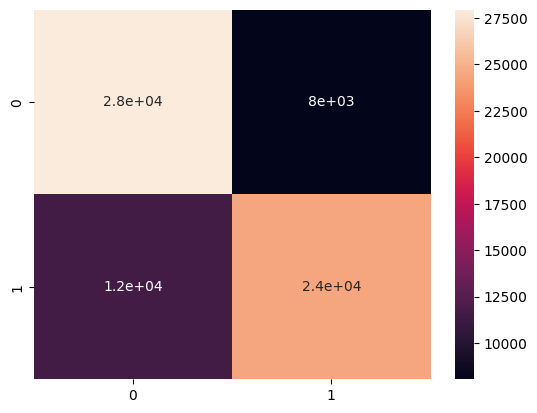

In [90]:
sns.heatmap(cm, annot=True)

In [91]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

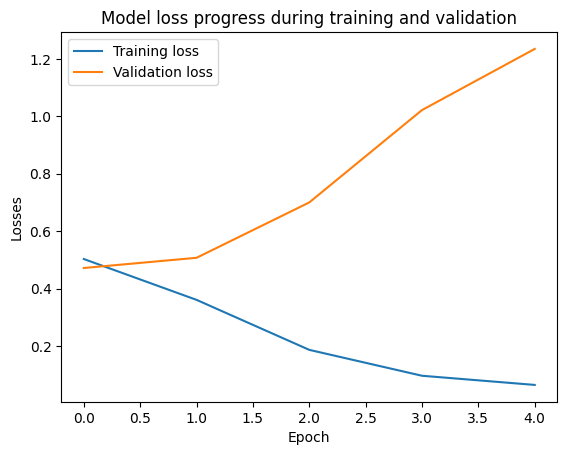

In [92]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Losses')
plt.legend(['Training loss', 'Validation loss'])

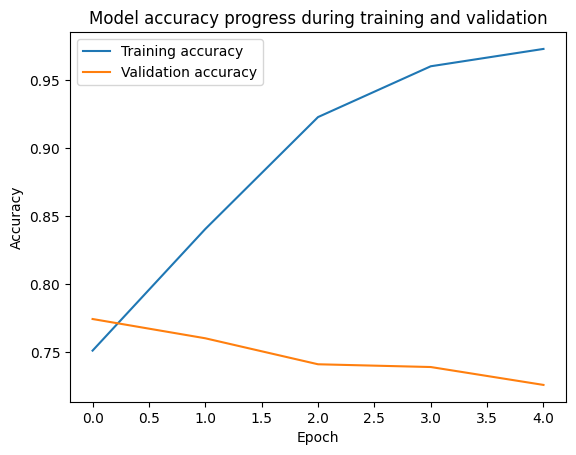

In [93]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy progress during training and validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training accuracy', 'Validation accuracy'])

## Previsões

In [94]:
text = 'i hate you'
text = tokenizer.encode(text)
text

[266, 65, 3158]

In [95]:
Dcnn(np.array([text]), training=False).numpy()

array([[0.00810922]], dtype=float32)